# SC3000 Lab 1 (Q-Learning)

Done By: Koh Yihao Kendrick (U2222663K) & Aaron Jerome Lim Li Yang (U2221616A)
<br>
Workload was equally shared between Kendrick and Aaron
<br>
This notebook showcases a thorough analysis on Q-Learning and its application in the CartPole gym environment

## Dependencies required to run notebook

In [1]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.3
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.6.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.5.0
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
beautifulsoup4                   4.12.3
bi

## Import statements

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt

import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from gym import logger as gymlogger
from gym.wrappers import RecordVideo

## Instantiating Gym environment

In [ ]:
env = gym.make("CartPole-v1", new_step_api=True)

# Task 1: Development of an RL agent

## Function create_bins_and_q_table()

create_bins_and_q_table() is used to create the q table

In this lab, we utilised a bin size of 20 and limited Cart Velocty and Pole Angular Velocity to -4 to 4
This decision was primarily influenced by insights gained from a specific video, which provided valuable visual evidence and context. For further details, please refer to the following link: [1].

Since there are 4 observations, the Q-table dimensions are determined by the number of bins in each dimension of the observation space and the number of actions in the environment's action space.

In [1]:
# Create bins and Q table
def create_bins_and_q_table():
	numBins = 20
	obsSpaceSize = len(env.observation_space.high)

	# Get the size of each bucket
	bins = [
		np.linspace(-4.8, 4.8, numBins),
		np.linspace(-4, 4, numBins),
		np.linspace(-.418, .418, numBins),
		np.linspace(-4, 4, numBins)
	]

	#Initialise empty Q-table
	qTable = np.zeros(([numBins] * obsSpaceSize + [env.action_space.n]))

	return bins, obsSpaceSize, qTable


## Function get_discrete_state()

get_discrete_state() is used to convert a continuous state representation into a discrete state index that can be used to index the Q-table.

For each dimension, the function finds the index of the bin that the state value falls into. This is done using np.digitize(state[i], bins[i]) - 1). - 1 is subtracted to convert the bin index to a zero-based index because indexing in Python starts from 0.

In [ ]:
# Given a state of the enviroment, return its descreteState index in qTable
def get_discrete_state(state, bins, obsSpaceSize):
	stateIndex = []
	for i in range(obsSpaceSize):
		stateIndex.append(np.digitize(state[i], bins[i]) - 1) # -1 will turn bin into index
	return tuple(stateIndex)

## Function training_q_learning()

training_q_learning() is used to train a Q-learning agent in a given environment.

### Parameters:
- `qTable`: The Q-table to be updated during training.
- `previousCnt`: A list to store the number of steps taken in each episode.
- `metrics`: A dictionary to store metrics for plotting the training progress.
- `bins`: Bins used for discretizing the continuous observation space.
- `obsSpaceSize`: The size of the observation space.

### Variables:
- `learning_rate`: The learning rate (alpha) determines to what extent newly acquired information overrides old information.
- `discount_rate`: The discount rate (gamma) determines the importance of future rewards. 
- `num_episodes`: The number of training episodes.
- `UPDATE_EVERY`: How often the current progress is recorded.
- `steps_per_episode`: Maximum number of steps per episode.

#### Exploration settings:
- `epsilon`: The exploration rate. Initially set to 1, it decays over time.
- `epsilon_start`: The start value for epsilon.
- `epsilon_end`: The end value for epsilon.
- `epsilon_decay_value`: Epsilon decaying rate.

### Training Process:
- For each episode:
  - Reset the environment and discretise the initial state.
  - Run the episode until termination or maximum steps:
    - Choose an action either randomly or greedily based on the current Q-table.
    - Perform the selected action in the environment.
    - Update the Q-table using the Q-learning update equation, NewQ = OldQ (1-a) + NewQ(a).
    - If the episode terminates due to failure or reaching the maximum steps, assign a negative reward.
    - Update the state.
  - Append the number of steps taken in the episode to `previousCnt`.
  - Decay epsilon if within the specified range of half of episodes.
  - Update metrics for plotting if the current episode is a multiple of `UPDATE_EVERY`.

In [ ]:
# Training for Q-learning
def training_q_learning(qTable, previousCnt, metrics, bins, obsSpaceSize):
	#--- VARIABLES ---
	# How much new info will override old info. 0 means nothing is learned, 1 means only most recent is considered, old knowledge is discarded
	learning_rate = 0.1

	# Between 0 and 1, mesue of how much we care about future reward over immedate reward
	discount_rate = 0.95
	num_episodes = 60000  # Number of iterations run
	SHOW_EVERY = 2000  # How often the current solution is rendered
	UPDATE_EVERY = 100  # How often the current progress is recorded
	steps_per_episode = 500 # Number of steps per episode

	# Exploration settings
	epsilon = 1  # not a constant, going to be decayed
	epsilon_start = 1
	epsilon_end = num_episodes // 2
	epsilon_decay_value = epsilon / (epsilon_end - epsilon_start)
	#--- VARIABLES ---

	for episode in range(num_episodes):
		discreteState = get_discrete_state(env.reset(), bins, obsSpaceSize)
		done = False  # has the enviroment finished?
		steps = 0  # Number of steps made

		while not done:
			steps += 1
			# Get action from Q table
			if np.random.random() > epsilon:
				action = np.argmax(qTable[discreteState])
			# Get random action
			else:
				action = np.random.randint(0, env.action_space.n)

			newState, reward, done, truncated, _ = env.step(action)  # perform action on enviroment

			newDiscreteState = get_discrete_state(newState, bins, obsSpaceSize)

			maxFutureQ = np.max(qTable[newDiscreteState])  # estimate of optiomal future value
			currentQ = qTable[discreteState + (action, )]  # old value

			# Pole falls over or over 500 steps, assign negative reward
			if done or steps > steps_per_episode:
				reward = -375
				break

			# formula to caculate all Q values
			newQ = (1 - learning_rate) * currentQ + learning_rate * (reward + discount_rate * maxFutureQ)
			qTable[discreteState + (action, )] = newQ  # Update qTable with new Q value

			discreteState = newDiscreteState

		previousCnt.append(steps)

		# Decaying is being done every run if run number is within decaying range
		if epsilon_end >= episode >= epsilon_start:
			epsilon -= epsilon_decay_value

		# Add new metrics for graph
		if episode % UPDATE_EVERY == 0:
			latestRuns = previousCnt[-UPDATE_EVERY:]
			averageCnt = sum(latestRuns) / len(latestRuns)
			metrics['ep'].append(episode)
			metrics['avg'].append(averageCnt)
			metrics['min'].append(min(latestRuns))
			metrics['max'].append(max(latestRuns))
			print("Run:", episode, "Average:", averageCnt, "Min:", min(latestRuns), "Max:", max(latestRuns))


	env.close()
	return qTable, previousCnt, metrics

## Calling of training_q_learning() with given metrics

training_q_learning() prints out average, minimum and maximum per 100 runs

In [ ]:
bins, obsSpaceSize, qTable = create_bins_and_q_table()

previousCnt = []  # array of all scores over runs
metrics = {'ep': [], 'avg': [], 'min': [], 'max': []}  # metrics recorded for graph

qTableTrained, previousCntTrained, metricTrained = training_q_learning(qTable, previousCnt, metrics, bins, obsSpaceSize)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Run: 0 Average: 17.0 Min: 17 Max: 17
Run: 100 Average: 20.56 Min: 8 Max: 50
Run: 200 Average: 20.95 Min: 9 Max: 53
Run: 300 Average: 22.22 Min: 8 Max: 78
Run: 400 Average: 22.46 Min: 10 Max: 88
Run: 500 Average: 23.26 Min: 9 Max: 64
Run: 600 Average: 22.39 Min: 9 Max: 90
Run: 700 Average: 23.63 Min: 10 Max: 67
Run: 800 Average: 23.5 Min: 10 Max: 81
Run: 900 Average: 22.79 Min: 9 Max: 59
Run: 1000 Average: 21.58 Min: 8 Max: 51
Run: 1100 Average: 25.86 Min: 10 Max: 68
Run: 1200 Average: 23.14 Min: 9 Max: 66
Run: 1300 Average: 23.91 Min: 9 Max: 70
Run: 1400 Average: 22.84 Min: 9 Max: 66
Run: 1500 Average: 24.47 Min: 9 Max: 74
Run: 1600 Average: 23.46 Min: 8 Max: 79
Run: 1700 Average: 25.18 Min: 8 Max: 61
Run: 1800 Average: 23.49 Min: 9 Max: 114
Run: 1900 Average: 23.84 Min: 10 Max: 74
Run: 2000 Average: 27.13 Min: 9 Max: 71
Run: 2100 Average: 22.84 Min: 10 Max: 67
Run: 2200 Average: 23.17 Min: 10 Max: 66
Run: 2300 Average: 25.92 Min: 10 Max: 68
Run: 2400 Average: 25.21 Min: 10 Max: 124
Ru

## Plotting of stored metrics for training

We observe a plateau average of 259.74 from run 59900-60000 which is sufficiently high as per lab requirements

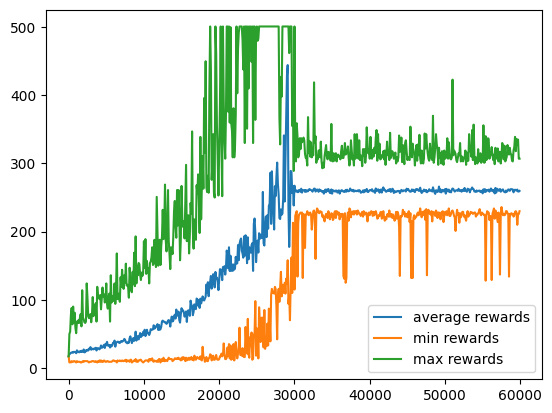

In [ ]:
# Plot graph
plt.plot(metricTrained['ep'], metricTrained['avg'], label="average rewards")
plt.plot(metricTrained['ep'], metricTrained['min'], label="min rewards")
plt.plot(metricTrained['ep'], metricTrained['max'], label="max rewards")
plt.legend(loc=4)
plt.show()

# Task 2: Demonstrate the effectiveness of the RL agent

## Function testing_q_learning()

testing_q_learning() is used to test a trained Q-learning agent in a given environment.

### Parameters:
- `qTable`: The trained Q-table previously returned from the training agent.
- `previousCnt`: A list to store the number of steps taken in each episode during testing.
- `metrics`: A dictionary to store metrics for plotting the testing progress.
- `bins`: Bins used for discretizing the continuous observation space.
- `obsSpaceSize`: The size of the observation space.
- `num_episodes`: The number of testing episodes (100).
- `env`: The environment used for testing.
- `envVideo`: The video rendering environment.
- `render`: A boolean flag indicating whether to render the environment during testing, used for rendering video in task 3.

### Variables:
- `step_per_episodes`: Maximum number of steps per episode during testing.
- `UPDATE_EVERY`: How often the current progress is recorded.

### Testing Process:
- For each episode:
  - Reset the environment and discretize the initial state.
  - Run the episode until termination or maximum steps:
    - Choose actions based on the trained Q-table.
    - Perform the selected actions in the environment.
    - Update the state.
  - Append the number of steps taken in the episode to `previousCnt`.
  - If rendering is enabled, visualize the environment.
  - If the episode terminates due to failure or reaching the maximum steps, terminate the episode.
  - If rendering is disabled, update metrics for plotting.

In [ ]:
#Test for Q-learning
def testing_q_learning(qTable, previousCnt, metrics, bins, obsSpaceSize, num_episodes, env, envVideo, render=False):
  step_per_episodes = 500
  UPDATE_EVERY = 10  # How often the current progress is recorded

  for episode in range(num_episodes):
    discreteState = get_discrete_state(env.reset(), bins, obsSpaceSize)
    done = False  # has the enviroment finished?
    steps = 0  # Number of steps made

    while not done:
      if render:
        envVideo.reset()
        envVideo.render()  # if running RL comment this out
      steps += 1
      action = np.argmax(qTable[discreteState])

      newState, reward, done, truncated, _ = env.step(action)  # perform action on enviroment
      newDiscreteState = get_discrete_state(newState, bins, obsSpaceSize)
      maxFutureQ = np.max(qTable[newDiscreteState])  # estimate of optiomal future value
      currentQ = qTable[discreteState + (action, )]  # old value

			# Pole falls over or over 500 steps, assign negative reward
      if done or steps > step_per_episodes:
        break

      discreteState = newDiscreteState

    previousCnt.append(steps)

		# Add new metrics for graph
    if not render:
      metrics['ep'].append(episode)
      metrics['reward'].append(previousCnt[episode])
      print("Reward for episode",episode,":", previousCnt[episode])
  if not render:
    averageCnt = sum(previousCnt) / len(previousCnt)
    print("Overall average:", averageCnt)


  env.close()
  return qTable, previousCnt, metrics

## Calling of testing_q_learning() with given metrics

testing_q_learning() prints out the reward per run, where num_episodes is set to 100

In [ ]:
previousCntTest = []  # array of all scores over runs
metricsTest = {'ep': [], 'reward': []}  # metrics recorded for graph

qTableTest, previousCntTest, metricTest = testing_q_learning(qTableTrained, previousCntTest, metricsTest, bins, obsSpaceSize, 100, env, env)

Reward for episode 0 : 257
Reward for episode 1 : 269
Reward for episode 2 : 277
Reward for episode 3 : 288
Reward for episode 4 : 251
Reward for episode 5 : 243
Reward for episode 6 : 293
Reward for episode 7 : 274
Reward for episode 8 : 247
Reward for episode 9 : 283
Reward for episode 10 : 282
Reward for episode 11 : 245
Reward for episode 12 : 249
Reward for episode 13 : 250
Reward for episode 14 : 227
Reward for episode 15 : 235
Reward for episode 16 : 250
Reward for episode 17 : 287
Reward for episode 18 : 262
Reward for episode 19 : 252
Reward for episode 20 : 233
Reward for episode 21 : 248
Reward for episode 22 : 243
Reward for episode 23 : 245
Reward for episode 24 : 264
Reward for episode 25 : 260
Reward for episode 26 : 241
Reward for episode 27 : 285
Reward for episode 28 : 273
Reward for episode 29 : 264
Reward for episode 30 : 260
Reward for episode 31 : 242
Reward for episode 32 : 284
Reward for episode 33 : 263
Reward for episode 34 : 265
Reward for episode 35 : 256
Re

## Plotting of stored metrics for testing¶

We observe a overall average of 260.63 which passes the lab requirements

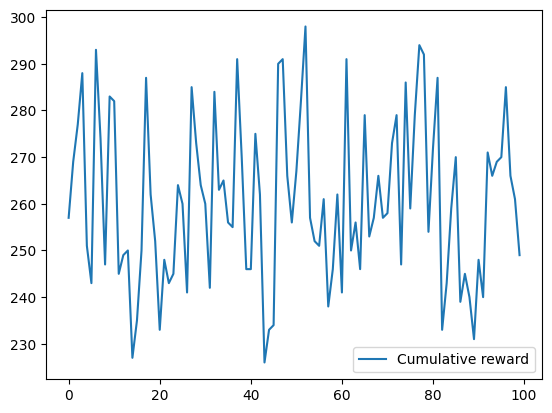

In [ ]:
# Plot graph
plt.plot(metricsTest['ep'], metricsTest['reward'], label="Cumulative reward")
plt.legend(loc=4)
plt.show()

# Task 3: Render one episode played by the developed RL agent

In [ ]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

## Rendering video

testing_q_learning() is called with render flag set to true, num_episodes is set to 1 and video rendering environment as parameter inputs

In [ ]:
envVideo = RecordVideo(gym.make("CartPole-v1"), "./video")
previousCntTest = []  # array of all scores over runs
metricsTest = {'ep': [], 'reward': []}  # metrics recorded for graph

testing_q_learning(qTableTrained, previousCntTest, metricsTest, bins, obsSpaceSize, 1, env, envVideo, render=True)

envVideo.close()
show_video()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environ

# Evaluation between Monte Carlo VS Q-Learning

In this lab exercise, we observed that the Monte Carlo algorithm outperformed Q-learning in the Cart Pole environment. With average rewards of 475.87 and 260.63 respectively during testing.


### Reasons for Performance Difference:

Our team believes the difference in performance was due to several factors:

1. **Parameter tuning**:
    - The performance of both agents could be influenced by the choice of hyperparameters, such as learning rates (Alpha), discount factors (Gamma), and exploration rates (Epsilon). In both cases, our team used similar hyperparameters which may have resulted in an untuned hyperparameters in Q-Learning which could have led to suboptimal performance compared to Monte Carlo.

2. **Limited training episodes**:
   - In our experiments, we limited the number of episodes in training to just 60k to fairly compare both agents, however, this could have led to the Q-Learning agent to producing suboptimal results due to insufficient exploration of the Cart Pole environment and learning process. With an increase in training episodes, Q-Learning could potentially outperform the Monte Carlo algorithm as more optimal policies are discovered

### Conclusion:

In this exercise, the Monte Carlo algorithm outperformed Q-learning. However, it is important to consider that agents perform differently in different problem domains. Therefore, We should still evaluate the strengths and weaknesses of both algorithms before employing them in future projects.

# References

[1] How to Use Q-Learning to Train Gymnasium CartPole-v1 | Python Reinforcement Learning Tutorial #3. (n.d.). Www.youtube.com. Retrieved March 18, 2024, from https://youtu.be/2u1REHeHMrg?si=-0S61-s5iOlkbnxk